In [ ]:
!pip install mesh_to_sdf pyrender trimesh
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0

     |████████████████████████████████| 1.2 MB 21.1 MB/s 
     |████████████████████████████████| 639 kB 30.8 MB/s 
     |████████████████████████████████| 890 kB 55.1 MB/s 
     |████████████████████████████████| 2.2 MB 41.2 MB/s 
  Created wheel for pyopengl: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=0bedb9864b33b984d401ee0dd4fbdf27cdc60c3809e2ccf6c2ccc1608a0d5f87
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
Successfully built pyopengl
  Attempting uninstall: pyopengl
    Found existing installation: PyOpenGL 3.1.5
    Uninstalling PyOpenGL-3.1.5:
      Successfully uninstalled PyOpenGL-3.1.5
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision v0.2.0) to /tmp/pip-req-build-6qg_6r1_
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-6qg_6r1_
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |███████████████

In [25]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes, Textures

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

# mesh_to_sdf lib by marian42
from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [26]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

In [27]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [28]:
!wget -nc -P ./data/ https://raw.githubusercontent.com/GalyuginAlexey/3D_ML/main/Homework%20%E2%84%961/Tiger.obj

File ‘./data/Tiger.obj’ already there; not retrieving.



In [29]:
path_to_model = os.path.join("data", "Tiger.obj")

In [30]:
# Trimesh Campfire.obj model
Tiger_trimesh = trimesh.load(path_to_model)

if isinstance(Tiger_trimesh, trimesh.Scene):
    Campfire_trimesh = Tiger_trimesh.dump(concatenate=True)

Campfire_trimesh.vertices -= Tiger_trimesh.center_mass
scaling = 2 / Tiger_trimesh.scale
Tiger_trimesh.apply_scale(scaling=scaling)

# Rainbow bunny in trimesh
# for facet in bunny_trimesh.facets:
#   bunny_trimesh.visual.face_colors[facet] = trimesh.visual.random_color() 

# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow bunny in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
Tiger_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [31]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a point light in front of the object. 
#lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


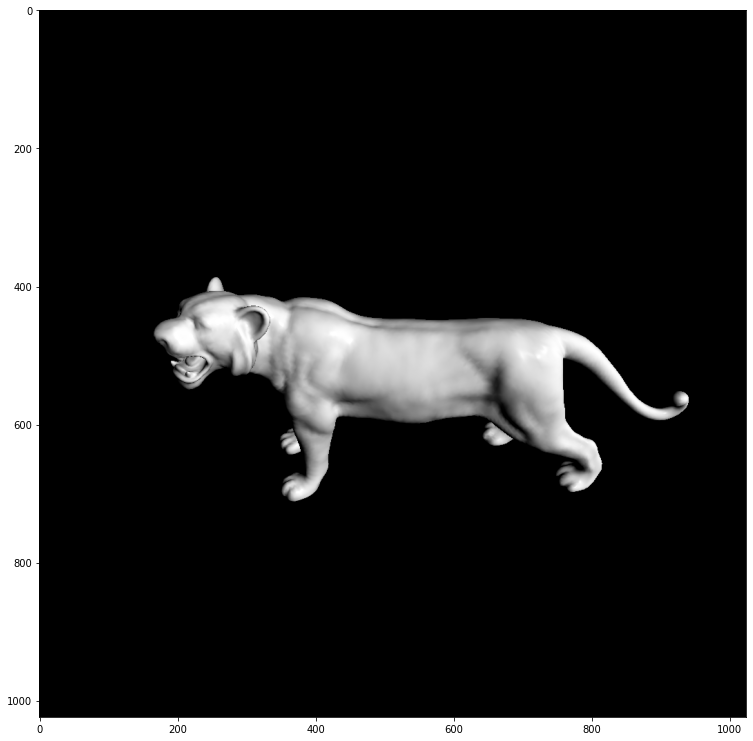

In [32]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the Campfire providing the values of R and T. 
image_Tiger = phong_renderer(meshes_world=Tiger_mesh, R=R, T=T)

image_Tiger = image_Tiger.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_Tiger.squeeze())
plt.grid(False)

In [33]:
print(
    "Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F =",
   Tiger_trimesh.euler_number
)


print("Is Tiger mesh watertight:", Tiger_trimesh.is_watertight)

print("Объем модели Campfire.obj:", Tiger_trimesh.volume)

# Объем единичной сферы 4/3 * Pi
(4/3)*np.pi

Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F = 2
Is Tiger mesh watertight: True
Объем модели Campfire.obj: 0.10245376702203118


4.1887902047863905

In [39]:
low_idx_Tiger = Tiger_trimesh.scale / 15
vox_low_Tiger = voxelize(Tiger_trimesh,pitch=low_idx_Tiger)
print("Размер воксельной сетки с низким разрешением:", vox_low_Tiger.shape)
print("Срез воксельной сетки:\n",np.array(vox_low_Tiger.matrix, dtype=np.uint8)[1])

Размер воксельной сетки с низким разрешением: (15, 7, 5)
Срез воксельной сетки:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [0 1 1 1 0]]


In [40]:
high_idx_Tiger = Tiger_trimesh.scale / 57
vox_high_Tiger = voxelize(Tiger_trimesh,pitch=high_idx_Tiger)
print("Размер воксельной сетки с высоким разрешением:", vox_high_Tiger.shape)
print("Срез воксельной сетки:\n",np.array(vox_high_Tiger.matrix, dtype=np.uint8)[1])

Размер воксельной сетки с высоким разрешением: (51, 24, 15)
Срез воксельной сетки:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [41]:
vox_high_Tiger.show()

In [42]:
center_mass = Campfire_trimesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

In [51]:
num_points_to_sample = 25000

Tiger_vert, Tiger_norm = sample_points_from_meshes(
    Tiger_mesh,
    num_points_to_sample ,
    return_normals=True
)

In [52]:
def plot_pointcloud(points, elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y,marker='.')  
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

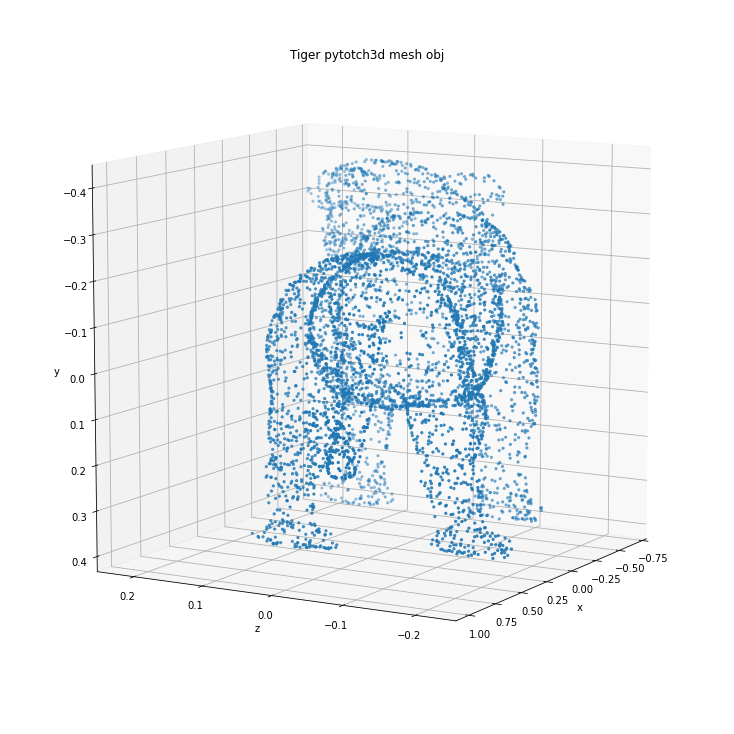

In [53]:
points = sample_points_from_meshes(Tiger_mesh, 5000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=150, title='Tiger pytotch3d mesh obj')